In [1]:
import os
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import wandb
from pytorch_lightning.loggers import WandbLogger

from image_dataset import ImageSequenceDataset


In [2]:
# Load annotations
annotation_path = "gcs/aaaaa/code/updated_dataset.pkl"
df = pd.read_pickle(annotation_path)
clip_label = df[['seq', 'gait_pat']].drop_duplicates()
clip_angle = df[['seq', 'cam_view']].drop_duplicates()
label_mapping = {row['seq']: row['gait_pat'] for idx, row in clip_label.iterrows()}
angle_mapping = {row['seq']: row['cam_view'] for idx, row in clip_angle.iterrows()}

print(angle_mapping)
# Load all sequence directories
image_dir = "gcs_images/gavd_frame_images"
sequence_dirs = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d)) and d.startswith('c')]
labels = [label_mapping[seq] for seq in sequence_dirs]

{'clld3ef9b003p3o6l1f3mrlez': 'back', 'clld3fen1003v3o6l9ecbpfk9': 'front', 'cll9v50ee004y3o6lj9djtcfk': 'back', 'cll9v6n7200523o6lbcj3iixb': 'front', 'cljwssdku00093n6lv3u03u8b': 'front', 'cljwstff4000d3n6ll71hchoj': 'front', 'cll9v88e7005b3o6lsm78vmuo': 'left side', 'cll9v8q89005f3o6loixx36b4': 'right side', 'cll9v9302005j3o6lcgyrlbkp': 'left side', 'cll9vb7gq005q3o6lmoiqs9sw': 'right side', 'cll9vdoyz00053o6lesqzcat4': 'left side', 'cll9ve3jb00093o6lsp1bg88v': 'right side', 'cll9vej3n000d3o6li0zfmfjh': 'front', 'cll9vewwu000h3o6lb7juql1r': 'back', 'cll9vfa44000l3o6luf8qzkqs': 'front', 'cll9vfq7v000p3o6l9ix6aagp': 'back', 'cll9vg9un000t3o6ledh37ba2': 'left side', 'cll9vgqli000x3o6lnyfwj9yf': 'right side', 'cljwsuzo5000i3n6l6fh04vn2': 'front', 'cljwsw2aj000n3n6l8leupj5h': 'right side', 'cll9vjtaw00133o6lyz1ucmc4': 'right side', 'cljwswmbz000r3n6lijh3r47s': 'left side', 'cljwswza1000v3n6lfl03wwes': 'right side', 'cljwsxudc000z3n6l8eoon4wq': 'left side', 'cljwsyscb00133n6lj5h5v9v1': 'ri

In [3]:
from collections import Counter

# Count occurrences of each label
label_counts = Counter(labels)

# Keep only classes with at least 2 samples
valid_classes = {label for label, count in label_counts.items() if count > 1}
filtered_dirs = [seq for seq, label in zip(sequence_dirs, labels) if label in valid_classes]
filtered_labels = [label for label in labels if label in valid_classes]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(filtered_labels)
# Create a mapping of labels to their encodings
label_to_encoding = {label: idx for idx, label in enumerate(label_encoder.classes_)}
encoding_to_label = {idx: label for label, idx in label_to_encoding.items()}
encoded_label_mapping = {idx: label_to_encoding[label] for idx, label in label_mapping.items()}

# Stratified split
train_dirs, temp_dirs, train_labels, temp_labels = train_test_split(
    filtered_dirs, y_encoded, stratify=y_encoded, test_size=0.4, random_state=42
)
val_dirs, test_dirs, val_labels, test_labels = train_test_split(
    temp_dirs, temp_labels, stratify=temp_labels, test_size=0.5, random_state=42)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [4]:
# Create Datasets
train_dataset = ImageSequenceDataset(
    clips=train_dirs,
    image_dir=image_dir,
    label_mapping=encoded_label_mapping,
    angle_mapping=angle_mapping,
    sequence_length=20,
    downsample_factor=5,
    transform=transform
)
val_dataset = ImageSequenceDataset(
    clips=val_dirs,
    image_dir=image_dir,
    label_mapping=encoded_label_mapping,
    angle_mapping=angle_mapping,
    sequence_length=20,
    downsample_factor=5,
    transform=transform
)
test_dataset = ImageSequenceDataset(
    clips=test_dirs,
    image_dir=image_dir,
    label_mapping=encoded_label_mapping,
    angle_mapping=angle_mapping,
    sequence_length=20,
    downsample_factor=5,
    transform=transform
)

# Make data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Label (encoded): 11
Angle (one-hot encoded): tensor([0., 0., 0., 1.])
Label (decoded): style
['gcs_images/gavd_frame_images/cljs3m7j800383n6lhtfqmad8/cljs3m7j800383n6lhtfqmad8_frame_3423.jpg', 'gcs_images/gavd_frame_images/cljs3m7j800383n6lhtfqmad8/cljs3m7j800383n6lhtfqmad8_frame_3428.jpg', 'gcs_images/gavd_frame_images/cljs3m7j800383n6lhtfqmad8/cljs3m7j800383n6lhtfqmad8_frame_3433.jpg', 'gcs_images/gavd_frame_images/cljs3m7j800383n6lhtfqmad8/cljs3m7j800383n6lhtfqmad8_frame_3438.jpg', 'gcs_images/gavd_frame_images/cljs3m7j800383n6lhtfqmad8/cljs3m7j800383n6lhtfqmad8_frame_3443.jpg', 'gcs_images/gavd_frame_images/cljs3m7j800383n6lhtfqmad8/cljs3m7j800383n6lhtfqmad8_frame_3448.jpg', 'gcs_images/gavd_frame_images/cljs3m7j800383n6lhtfqmad8/cljs3m7j800383n6lhtfqmad8_frame_3453.jpg', 'gcs_images/gavd_frame_images/cljs3m7j800383n6lhtfqmad8/cljs3m7j800383n6lhtfqmad8_frame_3458.jpg', 'gcs_images/gavd_frame_images/cljs3m7j800383n6lhtfqmad8/cljs3m7j800383n6lhtfqmad8_frame_3463.jpg', 'gcs_images/gav

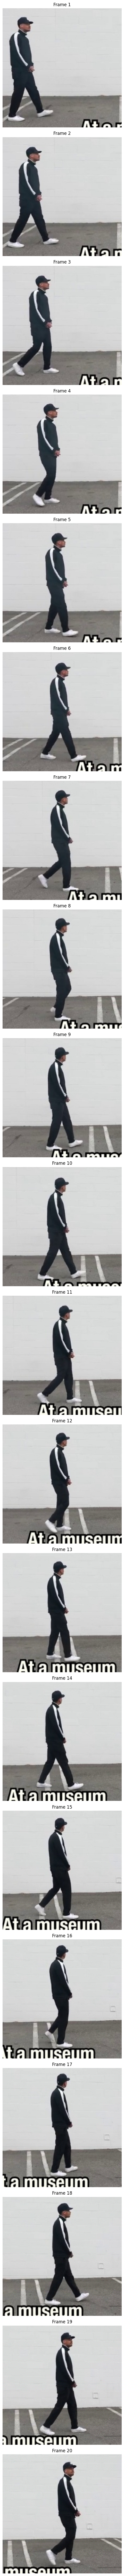

In [7]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

def visualize_sample(dataset, index):
    """
    Visualize a sample from the ImageSequenceDataset.
    
    Args:
        dataset: The ImageSequenceDataset object.
        index: The index of the sample to visualize.
    """
    # Retrieve the sample from the dataset
    sequence, label, angle, paths = dataset[index]
    
    # Print the label and angle
    print(f"Label (encoded): {label}")
    print(f"Angle (one-hot encoded): {angle}")
    
    print(f"Label (decoded): {encoding_to_label[label]}")
    print(paths)
    
    # Undo transformations if necessary
    if isinstance(sequence, torch.Tensor):
        # # Assuming the transform includes normalization, undo it
        # # Replace these means and stds with those used in your transform
        # mean = torch.tensor([0.485, 0.456, 0.406])  # Example ImageNet mean
        # std = torch.tensor([0.229, 0.224, 0.225])   # Example ImageNet std
        # inv_normalize = T.Normalize(mean=(-mean / std).tolist(), std=(1.0 / std).tolist())
        
        # # Denormalize the sequence
        # sequence = inv_normalize(sequence)
        sequence = sequence.permute(0, 2, 3, 1).numpy()  # Convert to HWC format
    
    # Visualize each image in the sequence
    num_frames = sequence.shape[0]
    fig, axes = plt.subplots(num_frames, 1, figsize=(100, 100))
    for i, ax in enumerate(axes):
        ax.imshow(sequence[i])
        ax.axis('off')
        ax.set_title(f"Frame {i + 1}")
    
    plt.tight_layout()
    plt.show()

# Example usage
visualize_sample(train_dataset, index=52)


In [ ]:
from cnn3d_model import CNN3D

# Initialize wandb
wandb.login(key='af968dcc6f77f75c5bcd9bfc39807a51bcecab9d')
wandb.init(project='3d-cnn-gait-analysis')

# Initialize the model
model = CNN3D(num_classes=len(label_to_encoding.items()), learning_rate=0.001)

# Initialize the wandb logger
wandb_logger = WandbLogger(project='3d-cnn-gait-analysis')

# Initialize the trainer
trainer = pl.Trainer(max_epochs=15, logger=wandb_logger)

# Train the model
trainer.fit(model, train_loader, val_loader)

# Test the model
trainer.test(model, test_loader)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hdlicht (henrylicht). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/henry/.netrc


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | conv1 | Conv3d    | 5.2 K  | train
1 | pool  | MaxPool3d | 0      | train
2 | conv2 | Conv3d    | 221 K  | train
3 | fc1   | Linear    | 1.4 B  | train
4 | fc2   | Linear    | 132 K  | train
5 | fc3   | Linear    | 3.1 K  | train
--------------------------------------------
1.4 B     Trainable params
0         Non-trainable params
1.4 B     Total params
5,756.035 Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:605: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv3d(


Training: |          | 0/? [00:00<?, ?it/s]